# Imports

In [27]:
import sys

sys.path.append("..")

from tools import *

# Parameters

In [ ]:
# Load options
params.reload_files = True
params.simulate_dead_area = True

# Save options
params.overwrite_metrics = True
params.save_figures = True

# Plotting options
params.flip_x = True
params.individual_plots = np.arange(1, 11, 1)
params.show_figures = True
params.label_font_size = 16
params.tick_font_size = 16
params.title_font_size = 18

# Events to process
params.event_list = None

# Noisy Pixels
params.channel_disable_list = [(7, (1, 2))]  # (chip, channel)


# Transform for real readout
params.detector_x = params.quadrant_size * 8
params.detector_y = params.quadrant_size * 8

# DBSCAN parameters for charge clustering
params.min_samples = 2
params.xy_epsilon = 8  # 8 ideal
params.z_epsilon = 8  # 8 ideal

# RANSAC parameters for line fitting
params.ransac_residual_threshold = (
    params.xy_epsilon - 1
)  # 6 ideal for charge, 35 ideal for light
params.ransac_max_trials = 1000
params.ransac_min_samples = 2  # 2 ideal for charge, 3 ideal for light

# Force parameters for cylinder
params.force_dh = None
params.force_dr = None

In [59]:
# File paths
charge_file = "/eos/experiment/dune/solar/montecarlo/singlecube/cosmic_v0/singlecube_cry_hit_0218622392_thrs3800.root"

In [60]:
params.output_folder = charge_file.split("_")[-1].split(".")[0]
if params.simulate_dead_area:
    params.work_path = "DA"

In [61]:
recal_params()
translation = montecarlo.get_translation()


Calculated parameters:
 dh_unit set to mm
 light_unit set to p.e.
 detector_x set to 256
 detector_y set to 256
 first_chip set to (1, 1)



# File handing

## Loading

In [62]:
temp_filename = f"{params.output_folder}/charge_df_{params.output_folder}.bz2"
if not params.reload_files and os.path.isfile(temp_filename):
    charge_df = pd.read_csv(temp_filename, index_col=0)
    if not params.event_list is None:
        charge_df = charge_df.loc[params.event_list.intersection(charge_df.index)]
    # for column in :
    charge_df[charge_df.columns[9:]] = charge_df[charge_df.columns[9:]].applymap(
        lambda x: literal_eval(x) if isinstance(x, str) else x
    )
else:
    charge_df = load_charge(charge_file, events=params.event_list)

del temp_filename

In [63]:
charge_df = montecarlo.rotate_coordinates(charge_df)

In [64]:
if params.simulate_dead_area:
    # Cut SiPMs from the anode
    charge_df = montecarlo.cut_sipms(charge_df)
    # Cut dead chips from anode
    charge_df = montecarlo.cut_chips(charge_df)

In [66]:
if any(t != 0 for t in translation):
    charge_df = montecarlo.translate_coordinates(charge_df, translation)

In [68]:
# Cut volume to live anode area
charge_df = montecarlo.cut_volume(charge_df)

## Saving

In [38]:
os.makedirs(params.output_folder, exist_ok=True)

In [39]:
# Only save files if all events were considered, i.e. event_list is None
if params.event_list is None:
    charge_df.to_csv(f"{params.output_folder}/charge_df_{params.output_folder}.bz2")

In [40]:
# Save parameters to JSON just in case
params_to_json(
    f"{params.output_folder}/reconstruction_parameters_{params.output_folder}.json"
)

## Verification

In [41]:
charge_df.columns

Index(['hit_x', 'hit_y', 'hit_z', 'hit_q', 'hit_qtrue', 'hit_tpc'], dtype='object')

In [42]:
charge_df.count()

hit_x        3629
hit_y        3629
hit_z        3629
hit_q        3629
hit_qtrue    3629
hit_tpc      3629
dtype: int64

### Histograms

#### Charge

Hits q in e


<Axes: >

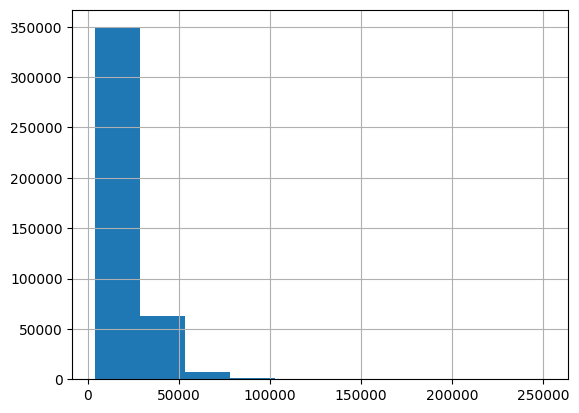

In [70]:
print(f"Hits q in {params.q_unit}")
charge_df["hit_q"].apply(tuple).explode().hist()

Hits x in mm


<Axes: >

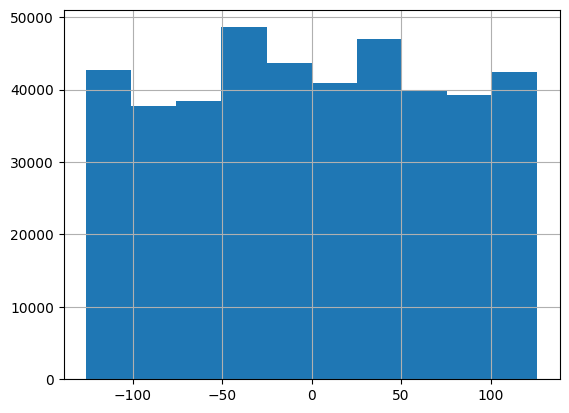

In [71]:
print(f"Hits x in {params.z_unit}")
charge_df["hit_x"].apply(tuple).explode().hist()

Hits y in mm


<Axes: >

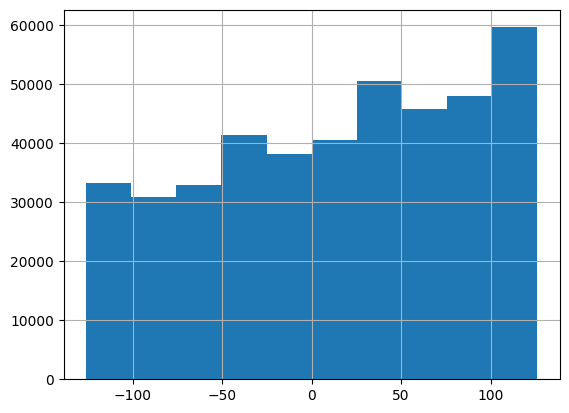

In [72]:
print(f"Hits y in {params.z_unit}")
charge_df["hit_y"].apply(tuple).explode().hist()

Hits z in mm


<Axes: >

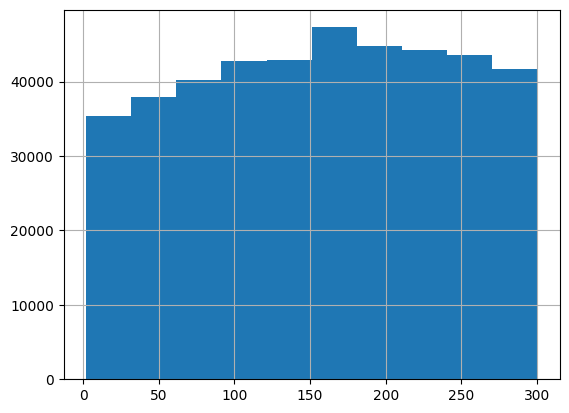

In [73]:
print(f"Hits z in {params.z_unit}")
charge_df["hit_z"].apply(tuple).explode().hist()

# Data fit

## Fake data map

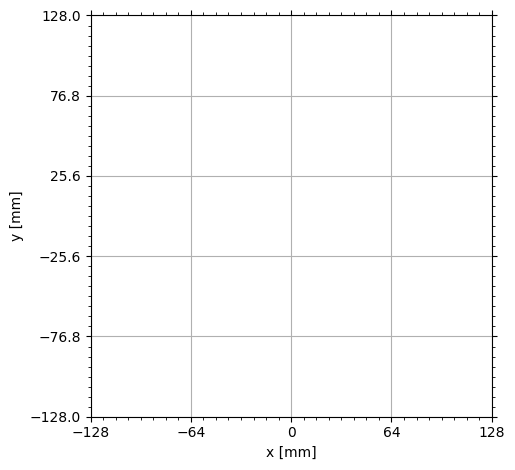

In [74]:
plot_fake_data(
    [1] if params.simulate_dead_area else [],
    buffer=(params.xy_epsilon - 1),
)
if params.show_figures:
    plt.show()
else:
    plt.close("all")

## Main loop

In [48]:
# Suppress the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=Warning, module="sklearn")

  0%|          | 0/3629 [00:00<?, ?it/s]

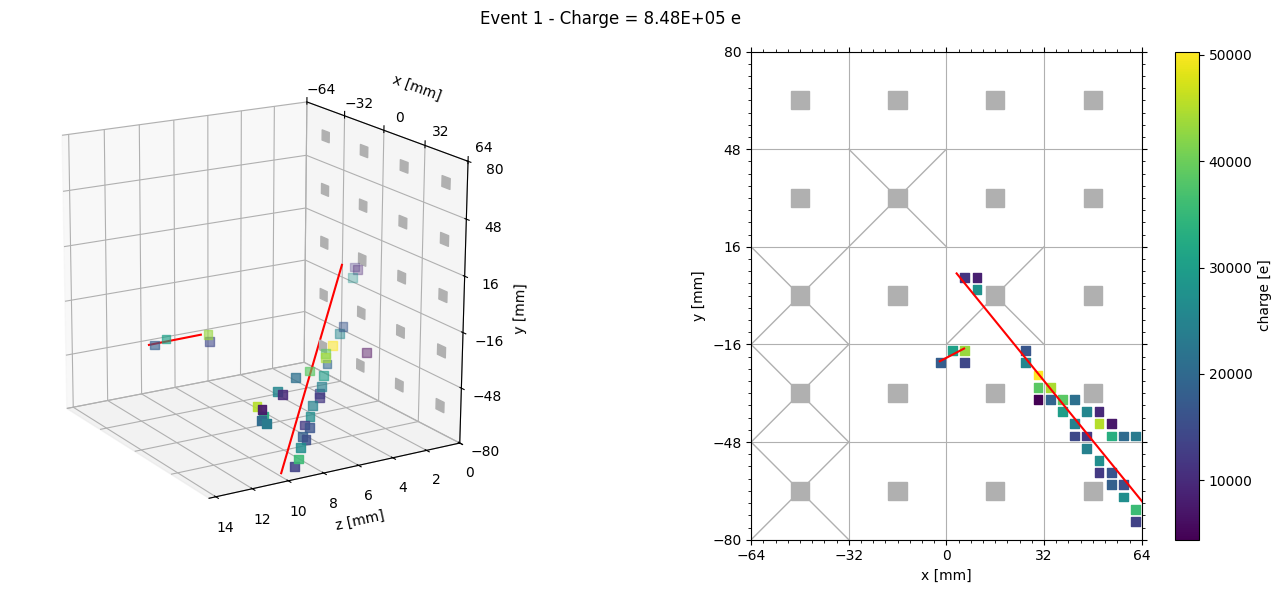

In [49]:
metrics = {}

if params.event_list is None:
    index_list = charge_df.index
else:
    index_list = charge_df.index.intersection(params.event_list)

for i, idx in enumerate(tqdm(index_list)):
    charge_values = pd.DataFrame(
        charge_df.loc[
            idx,
            [
                "hit_x",
                "hit_y",
                "hit_z",
                "hit_q",
            ],
        ].to_list(),
        index=["x", "y", "z", "q"],
    ).T

    # charge_values["q"] = charge_values["q"] * charge_gain  # Convert mV to ke

    if len(charge_values) > 2:
        # Create a design matrix
        labels = cluster_hits(
            charge_values[["x", "y", "z"]].to_numpy(),
        )
        # Fit clusters
        metrics[idx] = fit_hit_clusters(
            charge_values[["x", "y", "z"]].to_numpy(),
            charge_values["q"].to_numpy(),
            labels,
            # refit_outliers=False,
        )
        if idx in params.individual_plots:
            _ = event_display(
                event_idx=idx,
                charge_df=charge_values,
                metrics=metrics[idx],
                plot_cyl=False,
            )
            if params.show_figures:
                plt.show()
            else:
                plt.close()

        # metrics[idx][
        #     "Pixel_mask"
        # ] = mask.to_numpy()  # Save masks to original dataframe for reference
        metrics[idx]["Total_charge"] = charge_values["q"].sum()

In [50]:
# Reset the warning filter (optional)
warnings.filterwarnings("default", category=Warning)

## Metrics

In [51]:
# Save the metrics to a pickle file
metrics_file = f"{params.output_folder}/metrics_{params.output_folder}.pkl"
if params.overwrite_metrics or not os.path.isfile(metrics_file):
    with open(metrics_file, "wb") as f:
        pickle.dump(metrics, f)

    print(f"Metrics saved to {metrics_file}")

Metrics saved to thrs3800/metrics_thrs3800.pkl


In [52]:
metrics

{1: {1: {'Fit_line': Line(point=Point([ 35.74917495, -32.57035222,   6.6681614 ]), direction=Vector([ 0.62907739, -0.7734031 ,  0.07816191])),
   'Fit_norm': 103.03882763308208,
   'Fit_mse': 31.01809019744059,
   'RANSAC_score': -0.5529263736551764,
   'q_eff': 0.7732269343884552,
   'dQ': -17.173138          0.000000
   -5.724379           0.000000
    5.724379       47553.987305
    17.173138          0.000000
    28.621897      16756.857422
    40.070655      75863.349609
    51.519414     191920.931641
    62.968172      76360.854492
    74.416931      51196.337891
    85.865690      89219.724609
    97.314448      35733.804688
    108.763207         0.000000
    120.211966         0.000000
   dtype: float64,
   'dx': -17.173138      0.000000
   -5.724379       0.000000
    5.724379      11.448759
    17.173138      0.000000
    28.621897      3.289010
    40.070655     11.448759
    51.519414     11.448759
    62.968172     11.448759
    74.416931     11.448759
    85.865690     